In [6]:
import imgtda
from imgtda import standard_analysis as sa
from imgtda import computer_vision as cv

import numpy as np
import pandas as pd
from scipy import misc
from skimage import morphology as morph
from skimage import measure
import scipy
from scipy import ndimage as ndi
from PIL import Image

from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.animation as animation

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import pprint as pp

## Set Up Project

In [7]:
myproject = imgtda.Project

myproject['directory'] = '/Users/birdbrain/Documents/Research/Projects/Schatz/Data/g21chaotic/r4000_2015_09_16_fast'
myproject['bmp_format'] = 'g21flow/bmps/%06d.bmp'
myproject['pd_sub_format'] = 'g21flow/pd_sub/%06d.csv'
myproject['pd_sup_format'] = 'g21flow/pd_sup/%06d.csv'
myproject['additional_data'] = {'lyap_format':'g21per/bmps_abs_val/%05d.bmp',
                                'delta':10,
                                'lyap_out_format':'g21per/bmps_abs_val_smooth_6/%05d.bmp',
                                'lyap_pdsub_format':'g21per/pd_sub_smooth_6/%05d.csv'}


## Utility Functions

In [8]:
def load_image_data(project, idx):
    
    im = imgtda.image.load_image_from_file(project['directory'] + "/" + (project['bmp_format'] % idx))
    im.load_sublevel_pd(project['directory'] + "/" + (project['pd_sub_format'] % idx))
    im.load_superlevel_pd(project['directory'] + "/" + (project['pd_sup_format'] % idx))
    return im

def load_lyap_data(project, idx):
    
    lyap = misc.imread(project['directory'] + "/" + (project['additional_data']['lyap_format'] % idx))
    return lyap

def load_lyap_pd_data(project, idx):
    
    lyap = pd.DataFrame(pd.read_csv(project['directory'] + "/" + (project['additional_data']['lyap_pdsub_format'] % idx)))
    return lyap

def cropping_region():

    c = np.zeros((421,421))
    centerx = 210
    centery = 210
    radius=200
    for i in range(c.shape[0]):
        for j in range(c.shape[1]):
            if ((i-centerx)**2 + (j-centery)**2 < radius**2):
                c[i,j] = 1
    c = c.astype(np.int)
    return c


def get_image_saddle_points(im, lowercutoff, uppercutoff, delta):
    
    # Generate persistent homology defect matrix
    ph_lower_saddles = im.persistence_diagrams['sub'].loc[(im.persistence_diagrams['sub']['dim']==0) & ((im.persistence_diagrams['sub']['death'] - im.persistence_diagrams['sub']['birth']) >= delta) & (im.persistence_diagrams['sub']['death']>=lowercutoff) & (im.persistence_diagrams['sub']['death']<=127)][['d_x','d_y']]
    ph_lower_saddles.columns = ['col', 'row']
    ph_tmp = im.persistence_diagrams['sub'].loc[(im.persistence_diagrams['sub']['dim']==1) & ((im.persistence_diagrams['sub']['death'] - im.persistence_diagrams['sub']['birth']) >= delta) & (im.persistence_diagrams['sub']['birth']>=lowercutoff) & (im.persistence_diagrams['sub']['birth']<=127)][['b_x','b_y']]
    ph_tmp.columns = ['col', 'row']
    ph_lower_saddles = pd.concat([ph_lower_saddles, ph_tmp])

    ph_upper_saddles = im.persistence_diagrams['sup'].loc[(im.persistence_diagrams['sup']['dim']==0) & ((im.persistence_diagrams['sup']['birth'] - im.persistence_diagrams['sup']['death']) >= delta) & (im.persistence_diagrams['sup']['death']>=127) & (im.persistence_diagrams['sup']['death']<=uppercutoff)][['d_x','d_y']]
    ph_upper_saddles.columns = ['col', 'row']
    ph_tmp = im.persistence_diagrams['sup'].loc[(im.persistence_diagrams['sup']['dim']==1) & ((im.persistence_diagrams['sup']['birth'] - im.persistence_diagrams['sup']['death']) >= delta) & (im.persistence_diagrams['sup']['birth']>=127) & (im.persistence_diagrams['sup']['birth']<=uppercutoff)][['b_x','b_y']]
    ph_tmp.columns = ['col', 'row']
    ph_upper_saddles = pd.concat([ph_upper_saddles, ph_tmp])
    
    saddle_points = pd.concat([ph_lower_saddles, ph_upper_saddles])
    
    saddle_matrix = np.zeros(im.bmp.shape)
    saddle_matrix[saddle_points['row'], saddle_points['col']] = 1

    return saddle_matrix


def get_image_plumes(im, lowercutoff, uppercutoff, delta):
    
    # Generate persistent homology defect matrix
    ph_lower_plumes = im.persistence_diagrams['sub'].loc[(im.persistence_diagrams['sub']['dim']==1) & ((im.persistence_diagrams['sub']['death'] - im.persistence_diagrams['sub']['birth']) >= delta) & (im.persistence_diagrams['sub']['death']<=uppercutoff) & (im.persistence_diagrams['sub']['birth']<=127)][['d_x','d_y']]
    ph_lower_plumes.columns = ['col', 'row']

    ph_upper_plumes = im.persistence_diagrams['sup'].loc[(im.persistence_diagrams['sup']['dim']==1) & ((im.persistence_diagrams['sup']['birth'] - im.persistence_diagrams['sup']['death']) >= delta) & (im.persistence_diagrams['sup']['birth']>=127) & (im.persistence_diagrams['sup']['death']>=lowercutoff)][['d_x','d_y']]
    ph_upper_plumes.columns = ['col', 'row']
    
    plumes = pd.concat([ph_lower_plumes, ph_upper_plumes])
    
    plume_matrix = np.zeros(im.bmp.shape)
    plume_matrix[plumes['row'], plumes['col']] = 1

    return plume_matrix

def get_image_defects(idx, sigma, lowercutoff, uppercutoff, delta):

    im = load_image_data(myproject, idx)
    
    im.generate_orientation_field(sigma,1)
    im.orientation_fields[sigma].topological_defects_list = sa.topological_defect_array_to_dataframe(im.orientation_fields[sigma].topological_defects)
    im.saddle_points = get_image_saddle_points(im, lowercutoff, uppercutoff, delta)
    im.plumes = get_image_plumes(im, lowercutoff, uppercutoff, delta)

    return im

def generate_smoothed_lyap(idx, lyap_sigma, lyap):
    
    lyap = scipy.ndimage.filters.gaussian_filter(lyap, sigma=lyap_sigma)*2.
    lyap[lyap>=1.] = 1.
    
    lyap = (lyap*255.).astype(np.int)
    
    c = cropping_region()
    lyap = np.multiply(lyap, c)
    
    misc.imsave(myproject['directory'] + "/" + (myproject['additional_data']['lyap_out_format'] % idx), lyap)
    
    return 1
    

## Preprocess data for animation

### Functions for processing

In [9]:
def get_td_velocities(current, prior, distance_cutoff):
    
    types = [1., -1.]
    
    current['velocity'] = distance_cutoff
    current['matchedid'] = -1
    

    if not prior.empty:
        for t in types:
            type_matches = cv.match_points(current.ix[current.type == t,['row', 'col']], prior.loc[prior.type == t,['row', 'col']], distance_cutoff)
            current.ix[current.type==t, 'velocity'] = type_matches[:,1]
            current.ix[current.type==t, 'matchedid'] = type_matches[:,0].astype(np.int)
            
    return current

def get_defect_regions(im, sigma, radius, wn_cutoff, wn_cutoff_low, prev_td, distance_cutoff, lyap_pd, lyap_vec, prev_img):
    
    # Return a list rather than a matrix for scatter plot with varying alphas.
    #topological_defects_dilated = morph.binary_dilation(im.orientation_fields[sigma].topological_defects, morph.disk(radius))
    
    saddle_points_dilated = morph.binary_dilation(im.saddle_points, morph.disk(radius))
    plumes_dilated = morph.binary_dilation(im.plumes, morph.disk(radius))
    all_ph_dilated = ((saddle_points_dilated+plumes_dilated)>0).astype(np.int)
    large_wn = (im.local_wavenumber >= wn_cutoff).astype(np.int)
    small_wn = (im.local_wavenumber <= wn_cutoff_low).astype(np.int)
        
    td_with_velocities = get_td_velocities(im.orientation_fields[sigma].topological_defects_list, prev_td, distance_cutoff)
    
    local_maxi = np.zeros(im.bmp.shape)
    local_maxi[lyap_pd['d_y'], lyap_pd['d_x']] = 1
    local_maxi = np.multiply(local_maxi, lyap_vec)
    
    lyap_maxima = np.asarray([ (i,j,local_maxi[i,j]) for (i,j) in np.argwhere(local_maxi)])
    lyap_maxima = pd.DataFrame(lyap_maxima, columns=['row', 'col', 'value'])
    
    l1_diff = np.abs(im.bmp - prev_img).astype(np.float)
    l1_diff = l1_diff/np.max(l1_diff)
    
    return (td_with_velocities, all_ph_dilated, large_wn, small_wn, lyap_vec, lyap_maxima, l1_diff)

def compose(f, x, n):
    if n == 0:
        return x
    return compose(f, f(x), n - 1)

def log_plus_one(x):
    return np.log10(10.*x+1)

def get_independence_values(A, B, area):
    p_AB = float(np.sum(np.multiply(A, B)))/area
    p_A = float(np.sum(A))/area
    p_B = float(np.sum(B))/area
    
    return (p_AB, p_A, p_B)
    

### Basic independence analysis

In [11]:
process_range = range(1000, 2000)
window = 0

# Topological defects
sigma = 3

# Plumes/saddles
lowercutoff = 45
uppercutoff = 200
delta = 10

# Wavenumber
wn_cutoff = 3.
wn_cutoff_low = 1.6

# Velocities
distance_cutoff = 7. # Beyond this radius, considered unmatched
high_velocity = 4. # Beyond this velocity, considered "fast"

# Lyapunov stuff
lyap_sigma = 6
lyap_cutoff = 1.
lyap_lower_cutoff = 0.

# Lyapunov peak selection
lyap_delta = 5.
lyap_radius = 15.

# Defect radii
defect_radii = [5, 10, 15]

# L1 cutoffs
l1_cutoffs = [0.25, 0.5, 0.75]

# Independence analysis
independence_analysis = {}

# Initialize probabilities
independence_analysis['td'] = {}
independence_analysis['saddle'] = {}
independence_analysis['plume'] = {}
independence_analysis['td*'] = {}
independence_analysis['l1_diff'] = {}

for radius in defect_radii:
    independence_analysis['td'][radius] = []
    independence_analysis['saddle'][radius] = []
    independence_analysis['plume'][radius] = []
    independence_analysis['td*'][radius] = []

independence_analysis['wn_low'] = []
independence_analysis['wn_high'] = []

for cutoff in l1_cutoffs:
    independence_analysis['l1_diff'][cutoff] = []

# Initialize indicator functions
indicators = {}

# Other useful stuff
c = cropping_region()
total_area = float(np.sum(c))
prev_td = pd.DataFrame([], columns=['row', 'col', 'type'])

for idx in range(process_range[0]-window, process_range[-1]+window+2):
    
    if idx % 10 == 0:
        print idx
    
    # Get all the stuff
    im = get_image_defects(idx, sigma, lowercutoff, uppercutoff, delta)
    im.local_wavenumber = sa.emb_wavenumber(im.bmp.astype(np.float), "difference", 10)*10.
    
        
    if idx == process_range[0]:
        prev_img = im.bmp.copy()
    
    # Get indicator function for high velocities
    td_with_velocities = get_td_velocities(im.orientation_fields[sigma].topological_defects_list, prev_td, distance_cutoff)
    td_with_velocities = td_with_velocities.loc[(td_with_velocities['velocity'] >= high_velocity)]
    td_high_velocity_points = np.zeros(im.bmp.shape)
    td_high_velocity_points[td_with_velocities['row'], td_with_velocities['col']] = 1
    
    # Get Lyapunov peaks and create indicator function
    lyap_pd = load_lyap_pd_data(myproject, idx)
    lyap_pd = lyap_pd.loc[(lyap_pd['dim']==1) & (lyap_pd['death'] - lyap_pd['birth'] >= lyap_delta)]
    lyap_ind = np.zeros(im.bmp.shape)
    lyap_ind[lyap_pd['d_y'], lyap_pd['d_x']] = 1
    lyap_ind = morph.binary_dilation(lyap_ind, morph.disk(lyap_radius))
    
    # Crop everything into a circular region
    im.bmp = np.multiply(im.bmp, c)
    im.orientation_fields[sigma].topological_defects = np.multiply(im.orientation_fields[sigma].topological_defects, c)
    im.saddle_points = np.multiply(im.saddle_points, c)
    im.plumes = np.multiply(im.plumes, c)
    im.local_wavenumber[c == 0] = np.median(im.local_wavenumber[c == 1])
    lyap_ind = np.multiply(lyap_ind, c)
    td_high_velocity_points = np.multiply(td_high_velocity_points, c)
    
    # Initialize dictionaries
    indicators[idx] = {}
    indicators[idx]['td'] = {}
    indicators[idx]['saddle'] = {}
    indicators[idx]['plume'] = {}
    indicators[idx]['td*'] = {}
    indicators[idx]['l1_diff'] = {}
    
    # Get local wavenumber indicators
    indicators[idx]['wn_low'] = np.multiply((im.local_wavenumber >= wn_cutoff).astype(np.int), c)
    indicators[idx]['wn_high'] = np.multiply((im.local_wavenumber <= wn_cutoff_low).astype(np.int), c)
    
    # Inflate each point-indicator function by specified radius and re-crop
    for radius in defect_radii:

        # Log the indicator functions
        indicators[idx]['td'][radius] = np.multiply(morph.binary_dilation(im.orientation_fields[sigma].topological_defects, morph.disk(radius)), c)
        indicators[idx]['saddle'][radius] = np.multiply(morph.binary_dilation(im.saddle_points, morph.disk(radius)), c)
        indicators[idx]['plume'][radius] = np.multiply(morph.binary_dilation(im.plumes, morph.disk(radius)), c)
        indicators[idx]['td*'][radius] = np.multiply(morph.binary_dilation(td_high_velocity_points, morph.disk(radius)), c)
        
    # Get l1_diff indicators
    for cutoff in l1_cutoffs:
                
        l1_diff = np.abs(im.bmp - prev_img).astype(np.float)
        l1_diff = l1_diff.copy()/np.max(l1_diff)
        
        indicators[idx]['l1_diff'][cutoff] = (l1_diff >= cutoff).astype(np.int)

    # Process the probabilities
    if (idx >= process_range[0]+window):
        
        for radius in defect_radii:

            td_ind = np.zeros(im.bmp.shape)
            saddle_ind = np.zeros(im.bmp.shape)
            plume_ind = np.zeros(im.bmp.shape)
            tds_ind = np.zeros(im.bmp.shape)

            # Get the union of all of the indicators
            for i in range(idx - 2*window, idx + 1):
                td_ind = np.maximum(td_ind, indicators[i]['td'][radius])
                saddle_ind = np.maximum(saddle_ind, indicators[i]['saddle'][radius])
                plume_ind = np.maximum(plume_ind, indicators[i]['plume'][radius])
                tds_ind = np.maximum(tds_ind, indicators[i]['td*'][radius])

            # Log the probabilities
            independence_analysis['td'][radius].append([idx-window] + list(get_independence_values(lyap_ind, td_ind, total_area)))
            independence_analysis['saddle'][radius].append([idx-window] + list(get_independence_values(lyap_ind, saddle_ind, total_area)))
            independence_analysis['plume'][radius].append([idx-window] + list(get_independence_values(lyap_ind, plume_ind, total_area)))
            independence_analysis['td*'][radius].append([idx-window] + list(get_independence_values(lyap_ind, tds_ind, total_area)))
            
        wn_low_ind = np.zeros(im.bmp.shape)
        wn_high_ind = np.zeros(im.bmp.shape)
        
        # Get the union of all of the indicators
        for i in range(idx - 2*window, idx + 1):
            wn_low_ind = np.maximum(wn_low_ind, indicators[i]['wn_low'])
            wn_high_ind = np.maximum(wn_high_ind, indicators[i]['wn_high'])
            
        independence_analysis['wn_low'].append([idx-window] + list(get_independence_values(lyap_ind, wn_low_ind, total_area)))
        independence_analysis['wn_high'].append([idx-window] + list(get_independence_values(lyap_ind, wn_high_ind, total_area)))
        
        
        for cutoff in l1_cutoffs:
            
            # Do the l1 differences
            l1_ind = np.zeros(im.bmp.shape)
            
            # Get the union of all of the indicators
            for i in range(idx - 2*window, idx + 1):
                
                l1_ind = np.maximum(l1_ind, indicators[i]['l1_diff'][cutoff])
            
            independence_analysis['l1_diff'][cutoff].append([idx-window] + list(get_independence_values(lyap_ind, l1_ind, total_area)))
        
        del indicators[idx - 2*window]

    prev_td = im.orientation_fields[sigma].topological_defects_list.copy()
    prev_img = im.bmp.copy()
    
    del prev_td['velocity']
    del prev_td['matchedid']
    

# Convert everything to pandas dataframes
df_columns = ['Frame', 'LF', 'L', 'F']

df_types = ['td', 'saddle', 'plume', 'td*']
for df_type in df_types:
    for radius in defect_radii:
        independence_analysis[df_type][radius] = pd.DataFrame(independence_analysis[df_type][radius], columns = df_columns)

df_types = ['wn_low', 'wn_high']
for df_type in df_types:
    independence_analysis[df_type] = pd.DataFrame(independence_analysis[df_type], columns=df_columns)

for cutoff in l1_cutoffs:
    independence_analysis['l1_diff'][cutoff] = pd.DataFrame(independence_analysis['l1_diff'][cutoff], columns = df_columns)
    

1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000


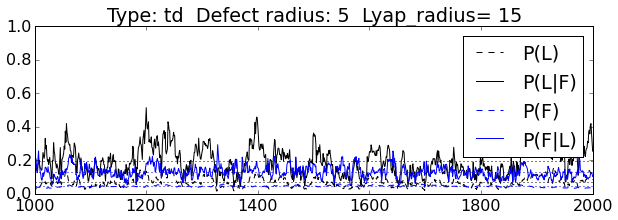

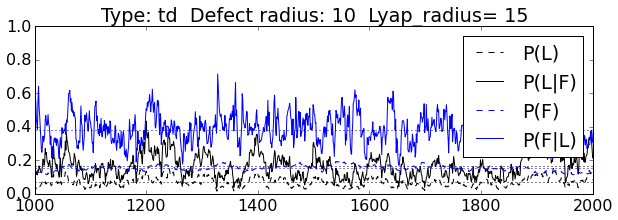

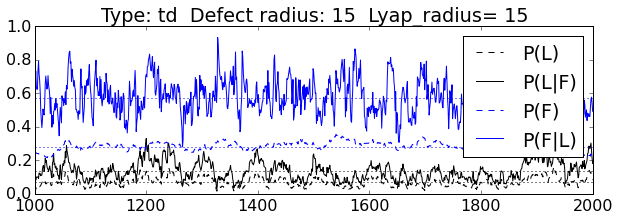

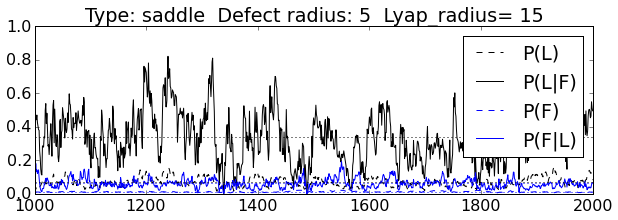

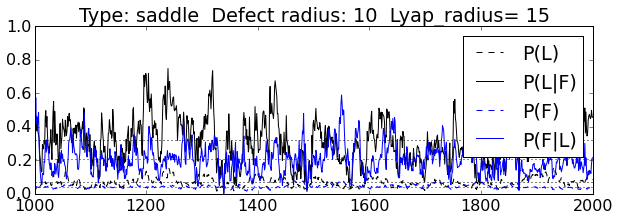

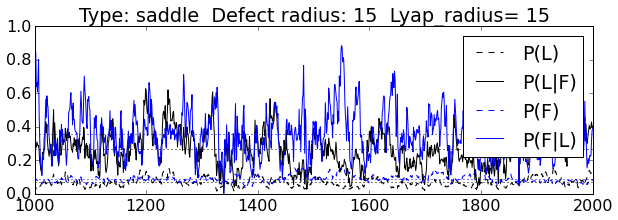

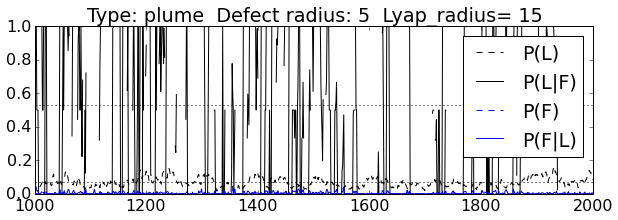

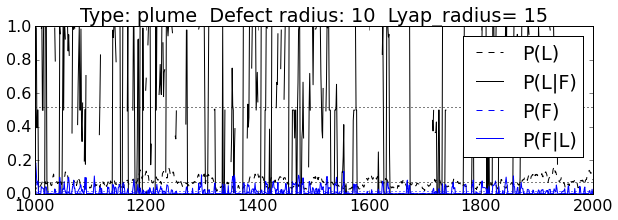

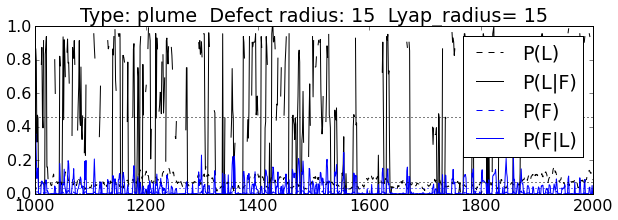

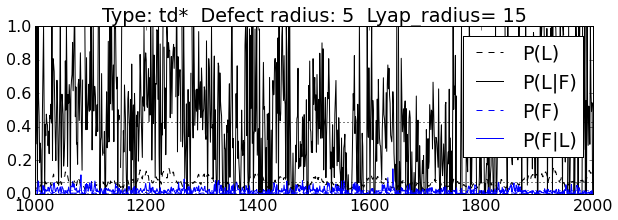

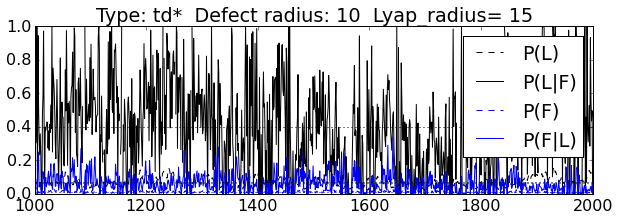

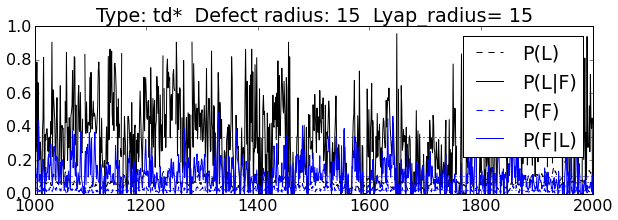

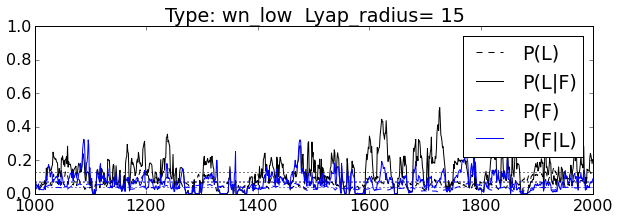

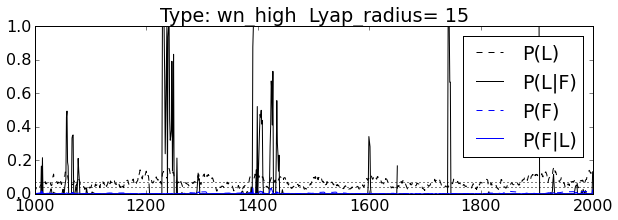

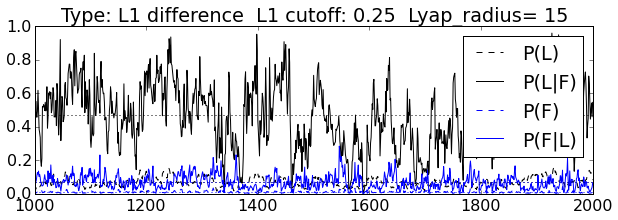

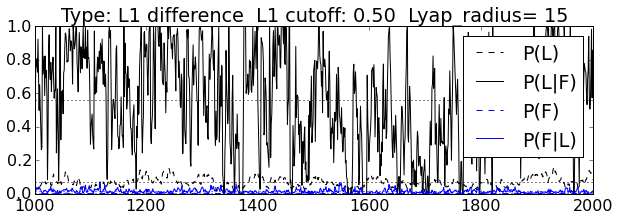

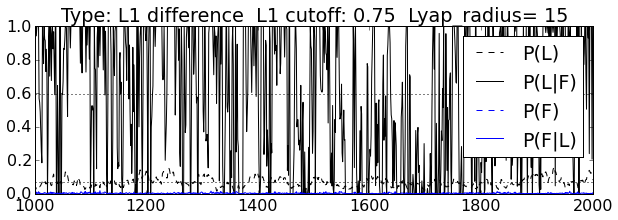

In [12]:
plt.rcParams['figure.figsize'] = (10.0, 3.0) 
plt.rcParams.update({'font.size': 16})

colors = ['black', 'black', 'blue', 'blue']

def plot_series(df, plot_title):
    plt.plot(df.Frame, df.L, '--', color=colors[0], label='P(L)')
    plt.plot(df.Frame, df.LF/df.F, color=colors[1], label='P(L|F)')
    plt.plot(df.Frame, df.F, '--', color=colors[2], label='P(F)')
    plt.plot(df.Frame, df.LF/df.L, color=colors[3], label='P(F|L)')
    
    plt.plot([df.Frame.iget(0), df.Frame.iget(-1)], [df.L.mean(), df.L.mean()], ':', color=colors[0])
    plt.plot([df.Frame.iget(0), df.Frame.iget(-1)], [(df.LF/df.F).mean(), (df.LF/df.F).mean()], ':', color=colors[1])
    plt.plot([df.Frame.iget(0), df.Frame.iget(-1)], [df.F.mean(), df.F.mean()], ':', color=colors[2])
    plt.plot([df.Frame.iget(0), df.Frame.iget(-1)], [(df.LF/df.L).mean(), (df.LF/df.L).mean()], ':', color=colors[3])
    
    plt.ylim([0,1])
    
    plt.legend()
    plt.title(plot_title)
    plt.show()

df_types = ['td', 'saddle', 'plume', 'td*']
for df_type in df_types:
    for radius in defect_radii:
        plot_series(independence_analysis[df_type][radius], 'Type: %s  Defect radius: %d  Lyap_radius= %d' % (df_type, radius, lyap_radius))

df_types = ['wn_low', 'wn_high']
for df_type in df_types:
    plot_series(independence_analysis[df_type], 'Type: %s  Lyap_radius= %d' % (df_type, lyap_radius))
    
for cutoff in l1_cutoffs:
    plot_series(independence_analysis['l1_diff'][cutoff], 'Type: %s  L1 cutoff: %0.2f  Lyap_radius= %d' % ('L1 difference', cutoff, lyap_radius))

## Render video

In [ ]:
process_range = range(1000, 1050)

# Topological defects
sigma = 3

# Plumes/saddles
lowercutoff = 45
uppercutoff = 200
delta = 10

# Wavenumber
wn_cutoff = 3.
wn_cutoff_low = 1.6

# Velocities
distance_cutoff = 7. # Beyond this radius, considered unmatched
high_velocity = 4. # Beyond this velocity, considered "fast"

# Lyapunov stuff
lyap_sigma = 6
lyap_cutoff = 1.
lyap_lower_cutoff = 0.

# Lyapunov peak selection
lyap_delta = 5.
lyap_radius = 15.

# Defect radii
defect_radii = [5, 10, 15]

# Independence analysis
independence_analysis = {}

# Initialize probabilities
independence_analysis['td'] = {}
independence_analysis['saddle'] = {}
independence_analysis['plume'] = {}
independence_analysis['td*'] = {}
independence_analysis['composite'] = {}

for radius in defect_radii:
    independence_analysis['td'][radius] = []
    independence_analysis['saddle'][radius] = []
    independence_analysis['plume'][radius] = []
    independence_analysis['td*'][radius] = []
    independence_analysis['composite'][radius] = []

independence_analysis['wn_low'] = []
independence_analysis['wn_high'] = []

# Other useful stuff
c = cropping_region()
prev_td = pd.DataFrame([], columns=['row', 'col', 'type'])
animation_data = {}

defect_radius = 15

for idx in process_range:
    
    if idx % 10 == 0:
        print idx
        
    if idx == process_range[0]:
        prev_img = im.bmp.copy()
    
    # Get all the stuff
    im = get_image_defects(idx, sigma, lowercutoff, uppercutoff, delta)
    im.local_wavenumber = sa.emb_wavenumber(im.bmp.astype(np.float), "difference", 10)*10.
    lyap = load_lyap_data(myproject, idx)
    lyap = lyap.astype(np.float)/255.
    
    # Get indicator function for high velocities
    td_with_velocities = get_td_velocities(im.orientation_fields[sigma].topological_defects_list, prev_td, distance_cutoff)
    td_with_velocities = td_with_velocities.loc[(td_with_velocities['velocity'] >= high_velocity)]
    td_high_velocity_points = np.zeros(im.bmp.shape)
    td_high_velocity_points[td_with_velocities['row'], td_with_velocities['col']] = 1
    
    # Get Lyapunov peaks and create indicator function
    lyap_pd = load_lyap_pd_data(myproject, idx)
    lyap_pd = lyap_pd.loc[(lyap_pd['dim']==1) & (lyap_pd['death'] - lyap_pd['birth'] >= lyap_delta)]
    lyap_ind = np.zeros(im.bmp.shape)
    lyap_ind[lyap_pd['d_y'], lyap_pd['d_x']] = 1
    lyap_ind = morph.binary_dilation(lyap_ind, morph.disk(lyap_radius))
    
    # Crop everything into a circular region
    im.bmp = np.multiply(im.bmp, c)
    im.orientation_fields[sigma].topological_defects = np.multiply(im.orientation_fields[sigma].topological_defects, c)
    im.saddle_points = np.multiply(im.saddle_points, c)
    im.plumes = np.multiply(im.plumes, c)
    im.local_wavenumber[c == 0] = np.median(im.local_wavenumber[c == 1])
    lyap_ind = np.multiply(lyap_ind, c)
    lyap = np.multiply(lyap, c)
    td_high_velocity_points = np.multiply(td_high_velocity_points, c)
    
    # Get local wavenumber indicators
    wn_high_ind = np.multiply((im.local_wavenumber >= wn_cutoff).astype(np.int), c)
    wn_low_ind = np.multiply((im.local_wavenumber <= wn_cutoff_low).astype(np.int), c)
    
    # Inflate each point-indicator function by specified radius and re-crop
    td_ind = morph.binary_dilation(im.orientation_fields[sigma].topological_defects, morph.disk(defect_radius))
    saddle_ind = morph.binary_dilation(im.saddle_points, morph.disk(defect_radius))
    plume_ind = morph.binary_dilation(im.plumes, morph.disk(defect_radius))
    td_vel_ind = morph.binary_dilation(td_high_velocity_points, morph.disk(defect_radius))

    # Re-crop
    td_ind = np.multiply(td_ind, c)
    saddle_ind = np.multiply(saddle_ind, c)
    plume_ind = np.multiply(plume_ind, c)
    td_vel_ind = np.multiply(td_vel_ind, c)

    composite_ind = np.multiply(np.maximum(np.maximum(saddle_ind, plume_ind), td_vel_ind), 1.-wn_low_ind)
    
    contours = measure.find_contours(im.bmp, 127.)
    
    l1_diff = np.abs(im.bmp - prev_img).astype(np.float)
    l1_diff = l1_diff/np.max(l1_diff)
    l1_diff = (l1_diff >= 0.25).astype(np.int)
    
    animation_data[idx] = {'contours': contours, 'lyap' : lyap, 'lyap_ind': lyap_ind, 'predictor_ind': composite_ind, 'l1_diff': l1_diff}
    
    prev_td = im.orientation_fields[sigma].topological_defects_list.copy()
    prev_img = im.bmp.copy()
    
    del prev_td['velocity']
    del prev_td['matchedid']
    


In [ ]:
def update_plot(ax, plot_data):
    
    lyap_color = np.dstack((np.zeros(plot_data['lyap'].shape), np.zeros(plot_data['lyap'].shape), np.zeros(plot_data['lyap'].shape), (1-plot_data['lyap'])*.5))
    lyap_ind_color = np.dstack((np.zeros(plot_data['lyap_ind'].shape), np.ones(plot_data['lyap_ind'].shape), np.ones(plot_data['lyap_ind'].shape), (plot_data['lyap_ind'])*.4))
    predictor_color = np.dstack((np.ones(plot_data['predictor_ind'].shape), np.ones(plot_data['predictor_ind'].shape), np.zeros(plot_data['predictor_ind'].shape), (plot_data['predictor_ind'])*.4))

    l1_color = np.dstack((np.ones(plot_data['l1_diff'].shape), np.zeros(plot_data['l1_diff'].shape), np.zeros(plot_data['l1_diff'].shape), (plot_data['l1_diff'])*1.))
    
    lyap_layer = ax.imshow(lyap_color, interpolation='nearest')
    lyap_ind_layer = ax.imshow(lyap_ind_color, interpolation='nearest')
    predictor_layer = ax.imshow(predictor_color, interpolation='nearest')
    l1_layer = ax.imshow(l1_color, interpolation='nearest')


    plot_contours = []
    for n, contour in enumerate(plot_data['contours']):
        pc = ax.plot(contour[:, 1], contour[:, 0], linewidth=1, color='black')
        plot_contours.append(pc)

    return (lyap_layer, lyap_ind_layer, predictor_layer, l1_layer, plot_contours)
    

In [ ]:
plt.rcParams['figure.figsize'] = (10.0, 10.0) 
fig = plt.figure();
ax = fig.add_subplot(111);
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None);
fig.gca().set_axis_off()

ax.set_xlim([0,im.bmp.shape[0]])
ax.set_ylim([im.bmp.shape[0], 0])

ims = []

for idx in process_range:
    
    print idx

    (lyap_layer, lyap_ind_layer, predictor_layer, l1_layer, plot_contours) = update_plot(ax, animation_data[idx])
    
    txt_title = ax.annotate("Frame %d\nCyan: Lyapunov peak indicator\nYellow: Predictor indicator" % idx, (10,35), color='white', fontsize=14)
    ax.axis('off')
    ims.append([lyap_layer, lyap_ind_layer, predictor_layer, l1_layer, txt_title] + [contour[0] for contour in plot_contours])

writer = animation.FFMpegWriter(bitrate=2000, fps=10)
anim = animation.ArtistAnimation(fig, ims, blit=True, repeat_delay=350)
anim.save(myproject['directory'] + ('/lyap_predictor_%d_%d.mp4' % (process_range[0], process_range[-1])), writer=writer)